In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
%matplotlib inline

In [2]:
data_dir = 'input_data'
seed=0
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'), index_col='ID')

## PCA Reduction

First, examining performance of a different PCA kernels

In [3]:
# Scaling features to means
std_scale = preprocessing.StandardScaler().fit(train_df.iloc[:, 1:])
train_df_scaled = std_scale.transform(train_df.iloc[:, 1:])

In [4]:
# Applying Box-Cox transform to target
train_df['target'] = stats.boxcox(train_df['target'])[0]

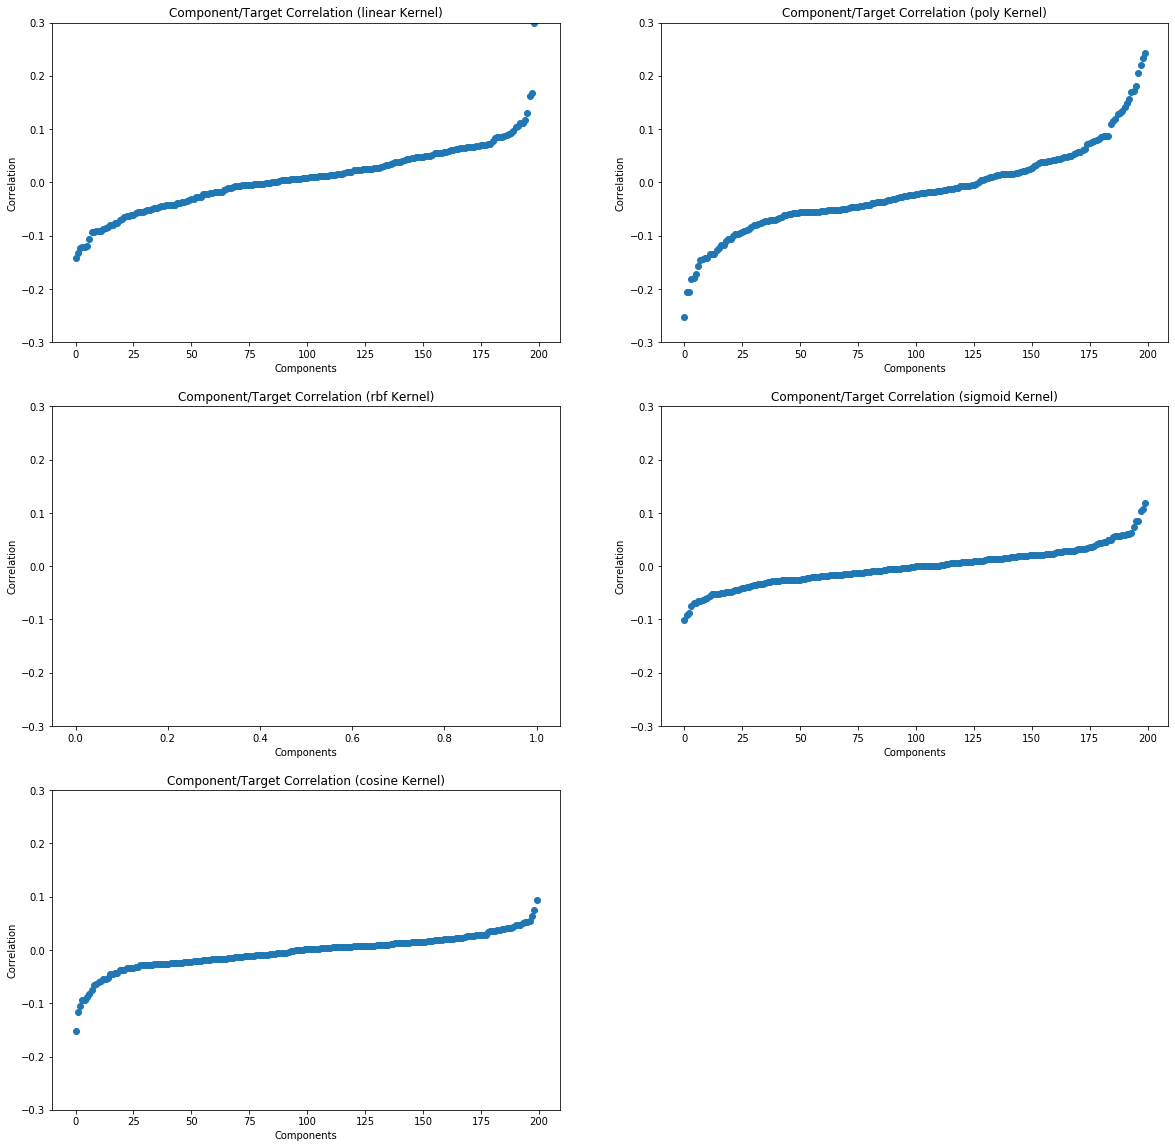

In [5]:
#Evaluating different PCA kernels
kernels=['linear', 'poly', 'rbf', 'sigmoid', 'cosine']
n_components=200

fig = plt.figure(figsize=(20, 20))

kernel_correlations = {}
kernel_df = {}
kernel_transformer = {}

for i, kernel in enumerate(kernels):
    kpca_sm = decomposition.KernelPCA(n_components=n_components, kernel=kernel)
    kpca_sm.fit(train_df_scaled)
    train_df_kpca = pd.concat([train_df['target'], pd.DataFrame(kpca_sm.transform(train_df.iloc[:, 1:].values), columns=['c{}'.format(num+1) for num in range(n_components)], index=train_df.index)], axis=1)
    correlation_kpca = train_df_kpca.corr(method='spearman')['target'][1:]
    
    #Saving results in dictionary for post-evaluation use
    kernel_correlations[kernel] = correlation_kpca
    kernel_df[kernel] = train_df_kpca
    kernel_transformer[kernel] = kpca_sm
    
    #Plotting results
    ax = fig.add_subplot(3, 2, i+1)
    ax.scatter(range(len(correlation_kpca)), np.sort(correlation_kpca))
    ax.set_title('Component/Target Correlation ({} Kernel)'.format(kernel))
    ax.set_xlabel('Components')
    ax.set_ylabel('Correlation')
    ax.set_ylim(-.3, .3)
    

The poly kernel appears to have the highest magnitude of correlations to the target. Before selecting an option, checking the performance of a sparse PCA method.

In [ ]:
sparse_sm = decomposition.SparsePCA(n_components=n_components)
sparse_sm.fit(train_df_scaled)
train_df_sparse = pd.concat([train_df['target'], pd.DataFrame(sparse_sm.transform(train_df.iloc[:, 1:].values), columns=['c{}'.format(num+1) for num in range(n_components)], index=train_df.index)], axis=1)
correlation_sparse = train_df_sparse.corr(method='spearman')['target'][1:]
kernel_correlations['sparse'] = correlation_sparse
kernel_df['sparse'] = train_df_sparse
plt.scatter(range(len(correlation_sparse)), np.sort(correlation_sparse))

## Choosing and Applying a PCA Model

PCA using a polynomial model appeared to perform the best. Selecting most correlated components and saving to a dataframe for regression modeling

In [ ]:
selected_kernel = 'sparse'
pca_threshold = .1

# Generating a dataframe of components with threshold-exceeding correlation to target
selected_correlations = kernel_correlations[selected_kernel]
best_components = selected_correlations[abs(selected_correlations) >= pca_threshold].sort_values(ascending=False)
pca_cols = [['target'] + list(best_components.index)][0]
train_df_final_pca = kernel_df[selected_kernel].loc[:, pca_cols]

In [ ]:
#Saving component-populated dataframe to local drive
train_df_final_pca.to_csv(os.path.join(data_dir, 'train_pca.csv'))

In [ ]:
# Freeing memory
train_df_final_pca = None
train_df = None

Transforming test data using PCA model

In [ ]:
#Reading in test data
import dask.dataframe as dd
chunksize = 1000
test_df_pca = pd.DataFrame()

for chunk in pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col='ID', chunksize=chunksize):
    test_df_pca = pd.concat([test_df_pca, chunk])

In [ ]:
#Transforming test data using selected PCA kernel
test_df_pca = pd.DataFrame(kernel_transformer[selected_kernel].transform(test_df_pca.values), columns=['c{}'.format(num+1) for num in range(n_components)], index=test_df_pca.index).loc[:, pca_cols]

In [ ]:
#Filtering columns based on training data correlations
test_df_pca = test_df_pca.loc[:, pca_cols]

In [ ]:
test_df_pca.to_csv(os.path.join(data_dir, 'test_pca.csv'))